In [49]:
import numpy as np
from tqdm import tqdm_notebook as tqdm


# Greedy approach (exploitation)

In [50]:
def pure_exploitation(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "Pure exploitation"
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# Random approach (exploration)

In [51]:
def pure_exploration(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "Pure exploration"
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):
        action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# Epsilon-greed (both exploration and exploitation)

In [52]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "E-greedy"
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):
        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


## Linear decay epsilon greed

In [53]:
def lin_dec_epsilon_greedy(
    env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.05, n_episodes=5000
):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "Lin e-greedy {} {} {}".format(init_epsilon, min_epsilon, decay_ratio)
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        decay_episodes = n_episodes * decay_ratio
        epsilon = 1 - e / decay_episodes
        epsilon *= init_epsilon - min_epsilon
        epsilon += min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)

        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


## Exponentially decaying epsilon-greddy strategy

In [54]:
def exp_dec_epsilon_greedy(
    env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.05, n_episodes=5000
):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), "edge")

    name = "exp e-greedy {} {} {}".format(init_epsilon, min_epsilon, decay_ratio)
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        if np.random.random() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# Optmistic Initialization strategy

In [55]:
def Optimistic_Initialization(
    env, Optimistic_estimate=0.1, initial_count=100, n_episodes=1000
):
    Q = np.full((env.action_space.n), Optimistic_estimate, dtype=np.float64)

    N = np.full((env.action_space.n), initial_count, dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "Optimistic {} {}".format(Optimistic_estimate, initial_count)
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# Testing

In [56]:
import gym
import gym_bandits
import numpy as np
from scipy.special import softmax as softmax_fn
from pprint import pprint
from tqdm.notebook import tqdm
# !pip install git+https://github.com/mimoralea/gym-bandits#egg=gym-bandits
from itertools import cycle

import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [57]:
plt.style.use("fivethirtyeight")
params = {
    "figure.figsize": (15, 8),
    "font.size": 24,
    "legend.fontsize": 20,
    "axes.titlesize": 28,
    "axes.labelsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)


In [58]:
env_name = "BanditTwoArmedUniform-v0"
env = gym.make(env_name, seed=12)
env.reset()


0

In [59]:
def tester_function(test_functions):
    results = {}
    for seed in tqdm(SEEDS, desc="All tests"):
        env = gym.make(env_name, seed=seed)
        env.reset()
        true_Q = np.array(env.env.p_dist * env.env.r_dist)
        opt_v = np.max(true_Q)
        for test_seed in tqdm(SEEDS, desc="All seeds"):
            for test_function in tqdm(
                test_functions, desc=f"Function with seed: {test_seed}"
            ):

                name, returns, Qe, actions = test_function(env)
                actions = np.expand_dims(actions, -1)
                episode_mean_rew = np.cumsum(returns) / (np.arange(len(returns)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, actions.shape), actions, axis=1
                ).squeeze()
                regret = opt_v - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {
                        "returns": [],
                        "Qe": [],
                        "actions": [],
                        "episode_mean_rew": [],
                        "cum_regret": [],
                    }
                results[name]["returns"].append(returns)
                results[name]["Qe"].append(Qe)
                results[name]["actions"].append(actions)
                results[name]["episode_mean_rew"].append(episode_mean_rew)
                results[name]["cum_regret"].append(cum_regret)
    return results


In [60]:
exp1 = [
    lambda env: pure_exploitation(env),
    lambda env: pure_exploration(env),
    lambda env: epsilon_greedy(env, epsilon=0.01, n_episodes=5000),
    lambda env: lin_dec_epsilon_greedy(env),
    lambda env: exp_dec_epsilon_greedy(env),
    lambda env: Optimistic_Initialization(env),
]


In [61]:
results = tester_function(exp1)


All tests:   0%|          | 0/5 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/6 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.01 0.05:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 0.1 100:   0%|          | 0/1000 [00:00<?, ?it/s]

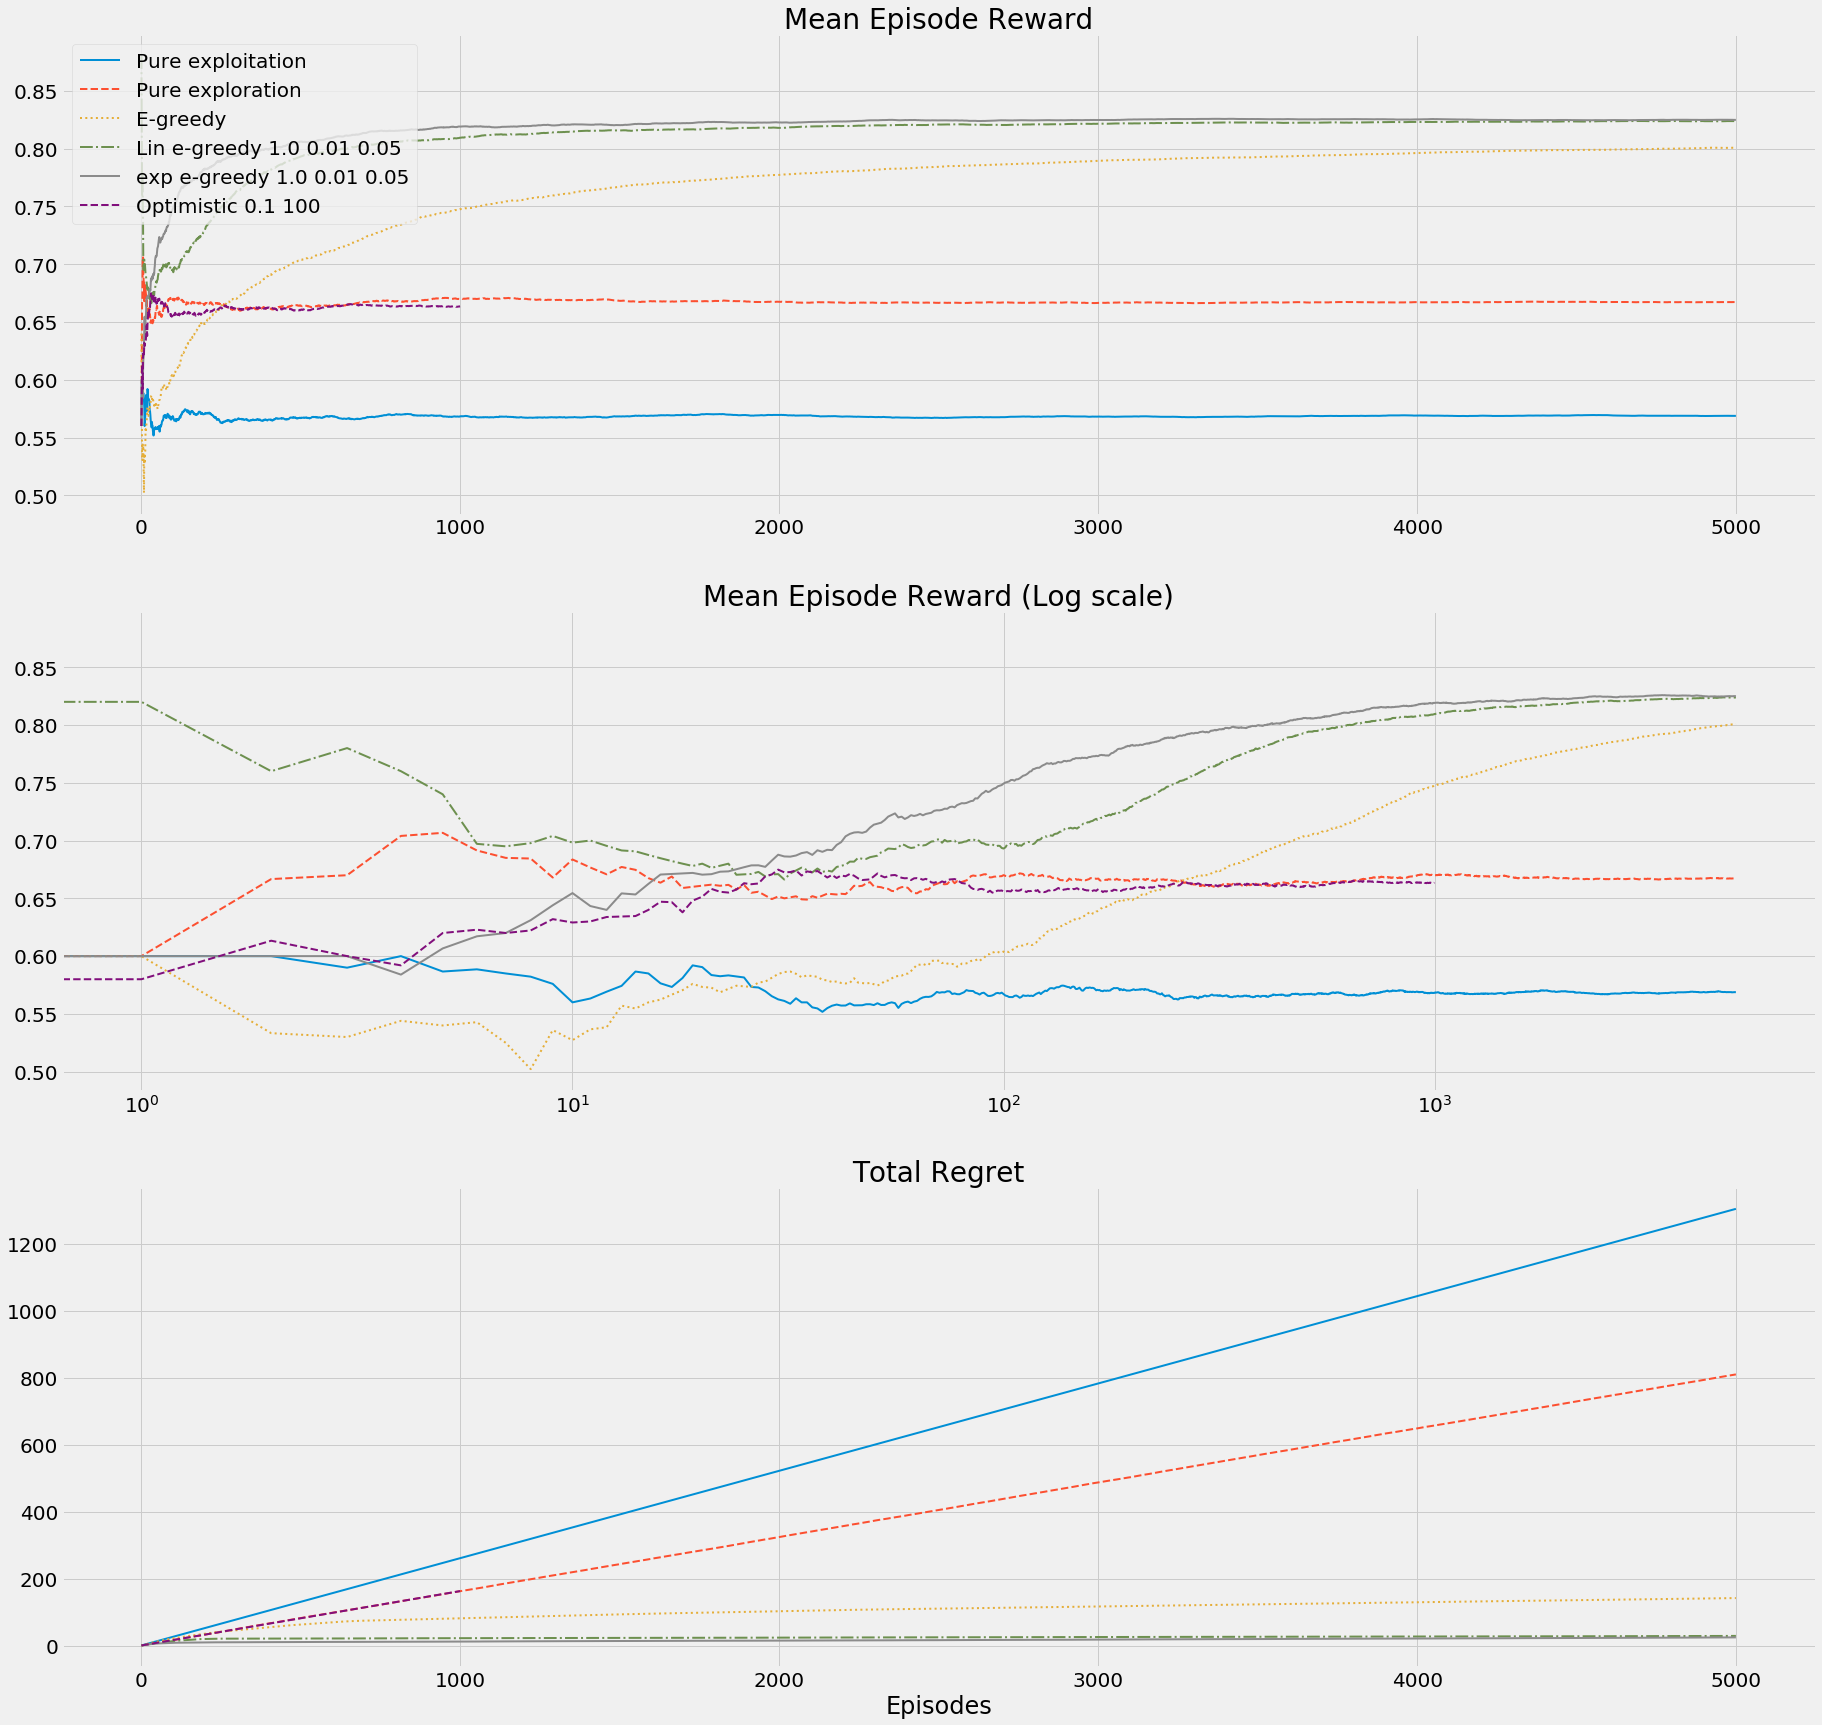

In [62]:
def plot(results):
    fig, axs = plt.subplots(3, 1, figsize=(28, 28), sharey=False, sharex=False)

    lines = ["-", "--", ":", "-."]
    linecycler = cycle(lines)
    min_reg, max_ret = float("inf"), float("-inf")
    for label, result in results.items():
        color = next(linecycler)

        # reward
        episode_mean_rew = np.array(result["episode_mean_rew"])
        mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

        axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

        axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
        axs[1].set_xscale("log")

        # regret
        cum_regret = np.array(result["cum_regret"])
        mean_cum_regret = np.mean(cum_regret, axis=0)

        axs[2].plot(mean_cum_regret, color, linewidth=2, label=label)

        # config plot
        axs[0].set_title("Mean Episode Reward")
        axs[1].set_title("Mean Episode Reward (Log scale)")
        axs[2].set_title("Total Regret")
        plt.xlabel("Episodes")
        axs[0].legend(loc="upper left")

    plt.show()


plot(results)


In [63]:
exp2 = [
    # baseline strategies
    lambda env: pure_exploitation(env),
    lambda env: pure_exploration(env),
    # epsilon greedy
    lambda env: epsilon_greedy(env, epsilon=0.07),
    lambda env: epsilon_greedy(env, epsilon=0.1),
    # epsilon greedy linearly decaying
    lambda env: lin_dec_epsilon_greedy(
        env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
    ),
    lambda env: lin_dec_epsilon_greedy(
        env, init_epsilon=0.3, min_epsilon=0.001, decay_ratio=0.1
    ),
    # epsilon greedy exponentially decaying
    lambda env: exp_dec_epsilon_greedy(
        env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
    ),
    lambda env: exp_dec_epsilon_greedy(
        env, init_epsilon=0.3, min_epsilon=0.0, decay_ratio=0.3
    ),
    # optimistic
    lambda env: Optimistic_Initialization(
        env, Optimistic_estimate=1.0, initial_count=10
    ),
    lambda env: Optimistic_Initialization(
        env, Optimistic_estimate=1.0, initial_count=50
    ),
]


In [64]:
results = tester_function(exp2)


All tests:   0%|          | 0/5 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 0.3 0.001 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 50:   0%|          | 0/1000 [00:00<?, ?it/s]

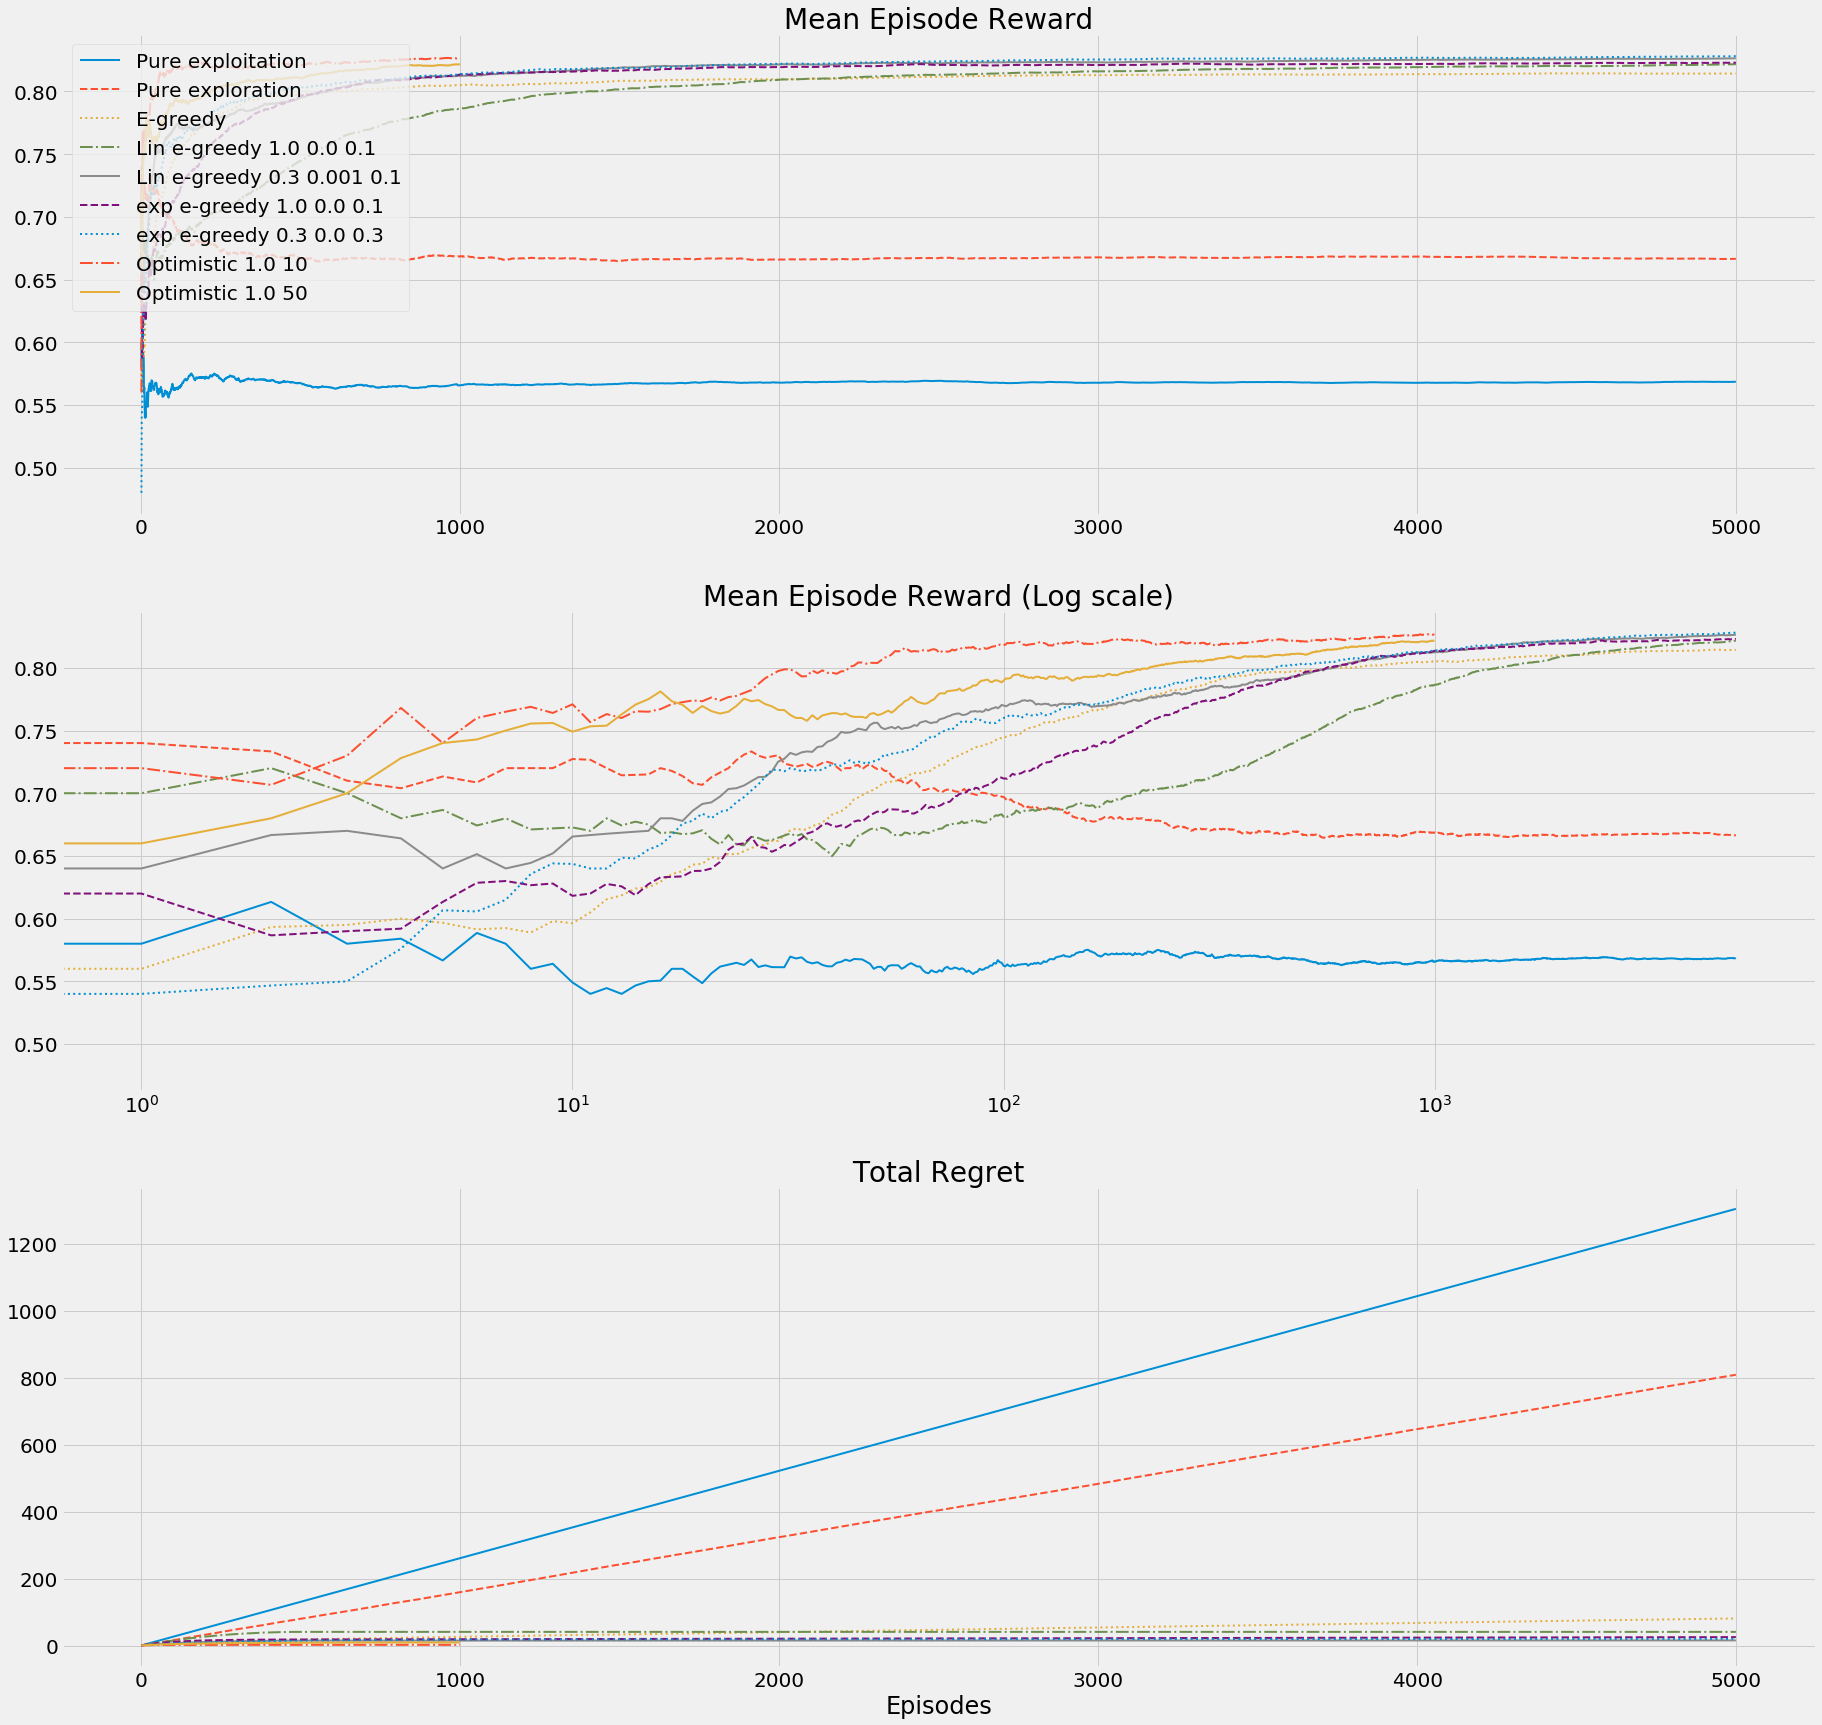

In [65]:
plot(results)


# Softmax

In [98]:
def softmax(
    env,
    init_temp=float("inf"),
    min_temp=0.0,
    decay_ratio=0.04,
    n_episodes=5000,
):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)

    init_temp = min(init_temp, 10e10)
    min_temp = max(min_temp, np.nextafter(np.float32(0), np.float32(1)))

    name = "Softmax {} {} {}".format(init_temp, min_temp, decay_ratio)
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        Scaled_Q = Q / temp
        norm_Q = Scaled_Q - np.max(Scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)

        assert np.isclose(np.sum(probs), 1.0)
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# UCB

In [99]:
def upper_confidence_bound(env, c=2, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = "UCB {}".format(c)
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        if e < len(Q):
            action = e
        else:
            U = c * np.sqrt(np.log(e) / N)
            action = np.argmax(U + Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


# Thompson Sampling Strategy

In [100]:
def thompson_sampling(env, alpha=1, beta=0, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    name = f"Thompson Sampling: {alpha} {beta}"
    for e in tqdm(range(n_episodes), desc="Episodes for:" + name, leave=False):

        samples = np.random.normal(loc=Q, scale=alpha / (np.sqrt(N) + beta))

        action = np.argmax(samples)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions


In [101]:
exp3 = [
    lambda env: pure_exploitation(env),
    lambda env: pure_exploration(env),
    # epsilon greedy
    lambda env: epsilon_greedy(env, epsilon=0.1),
    # epsilon greedy linearly decaying
    lambda env: lin_dec_epsilon_greedy(
        env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
    ),
    # epsilon greedy exponentially decaying
    lambda env: exp_dec_epsilon_greedy(
        env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
    ),
    # optimistic
    lambda env: Optimistic_Initialization(
        env, Optimistic_estimate=1.0, initial_count=10
    ),
    # advanced
    lambda env: softmax(env, init_temp=float("inf"), min_temp=0.0, decay_ratio=0.005),
    lambda env: softmax(env, init_temp=100, min_temp=0.01, decay_ratio=0.01),
    lambda env: upper_confidence_bound(env, c=0.2),
    lambda env: upper_confidence_bound(env, c=0.5),
    lambda env: thompson_sampling(env, alpha=1, beta=1),
    lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
]
results = tester_function(exp3)


All tests:   0%|          | 0/5 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7fc28cab08b0>
Traceback (most recent call last):
  File "/home/juno/.local/lib/python3.8/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/juno/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/12 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:E-greedy:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Lin e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 1.0 0.0 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

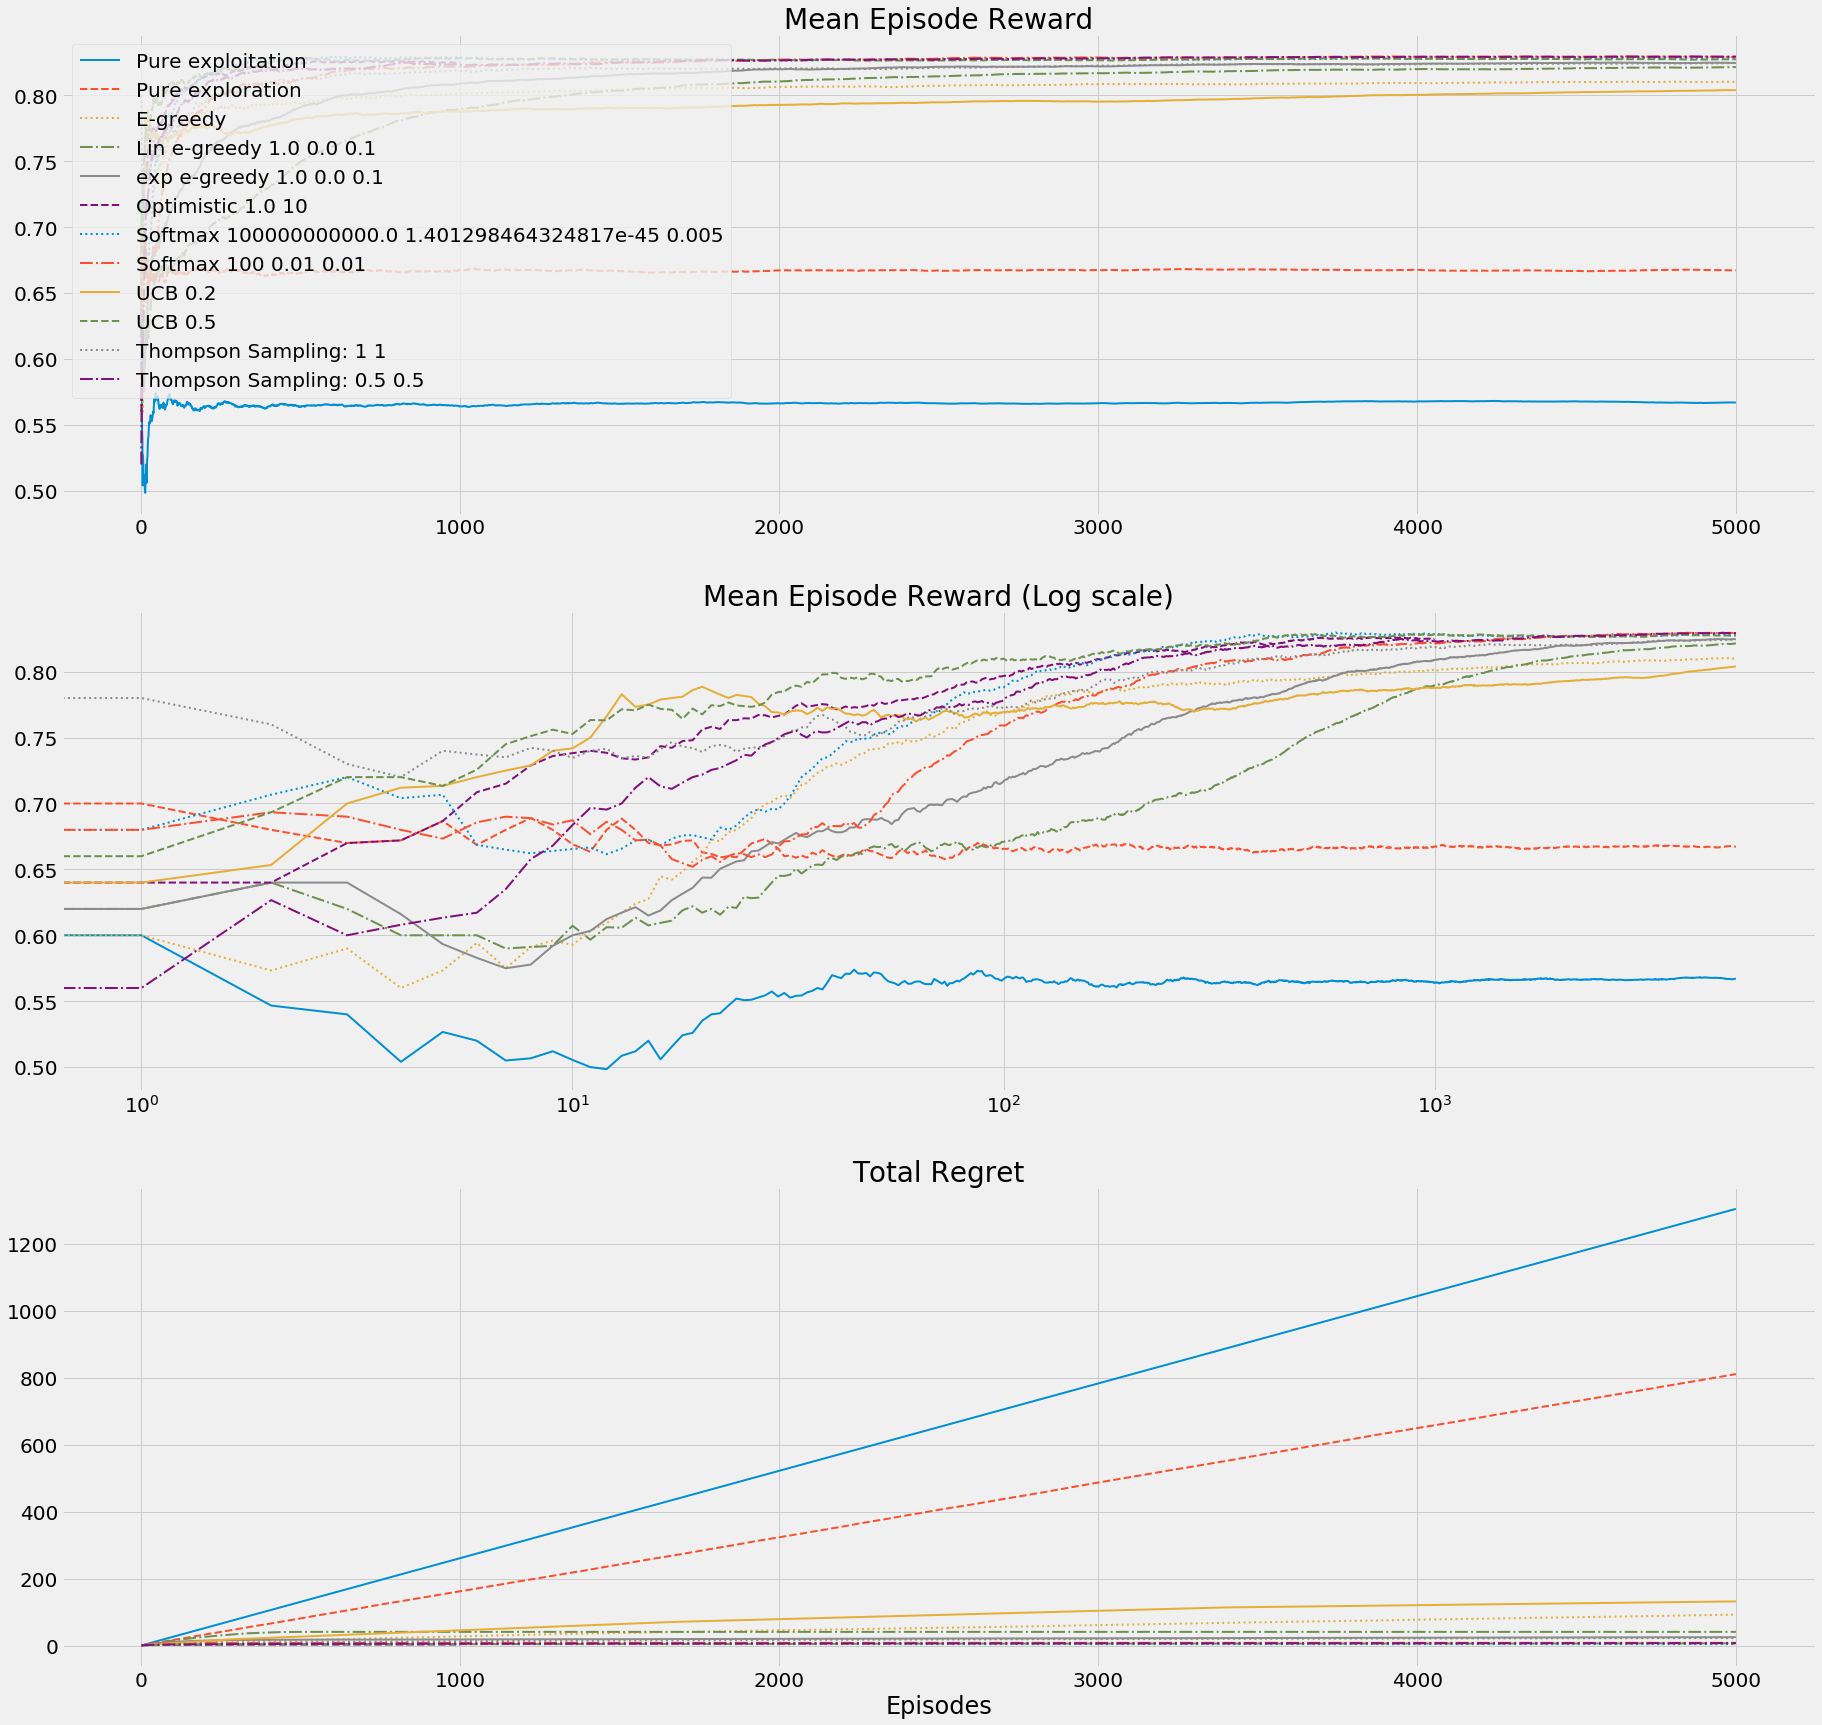

In [102]:
plot(results)


In [104]:
exp4 = [
    # baseline strategies
    lambda env: pure_exploitation(env),
    lambda env: pure_exploration(env),
    # best from simple strategies
    lambda env: Optimistic_Initialization(
        env, Optimistic_estimate=1.0, initial_count=10
    ),
    lambda env: exp_dec_epsilon_greedy(
        env, init_epsilon=0.3, min_epsilon=0.0, decay_ratio=0.3
    ),
    # softmax
    lambda env: softmax(env, init_temp=float("inf"), min_temp=0.0, decay_ratio=0.005),
    lambda env: softmax(env, init_temp=100, min_temp=0.01, decay_ratio=0.01),
    # ucb
    lambda env: upper_confidence_bound(env, c=0.2),
    lambda env: upper_confidence_bound(env, c=0.5),
    # thompson sampling
    lambda env: thompson_sampling(env, alpha=1, beta=1),
    lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
]
results = tester_function(exp4)


All tests:   0%|          | 0/5 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Function with seed: 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Function with seed: 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for:Pure exploitation:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Pure exploration:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Optimistic 1.0 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for:exp e-greedy 0.3 0.0 0.3:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100000000000.0 1.401298464324817e-45 0.005:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Softmax 100 0.01 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.2:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:UCB 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 1 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Episodes for:Thompson Sampling: 0.5 0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

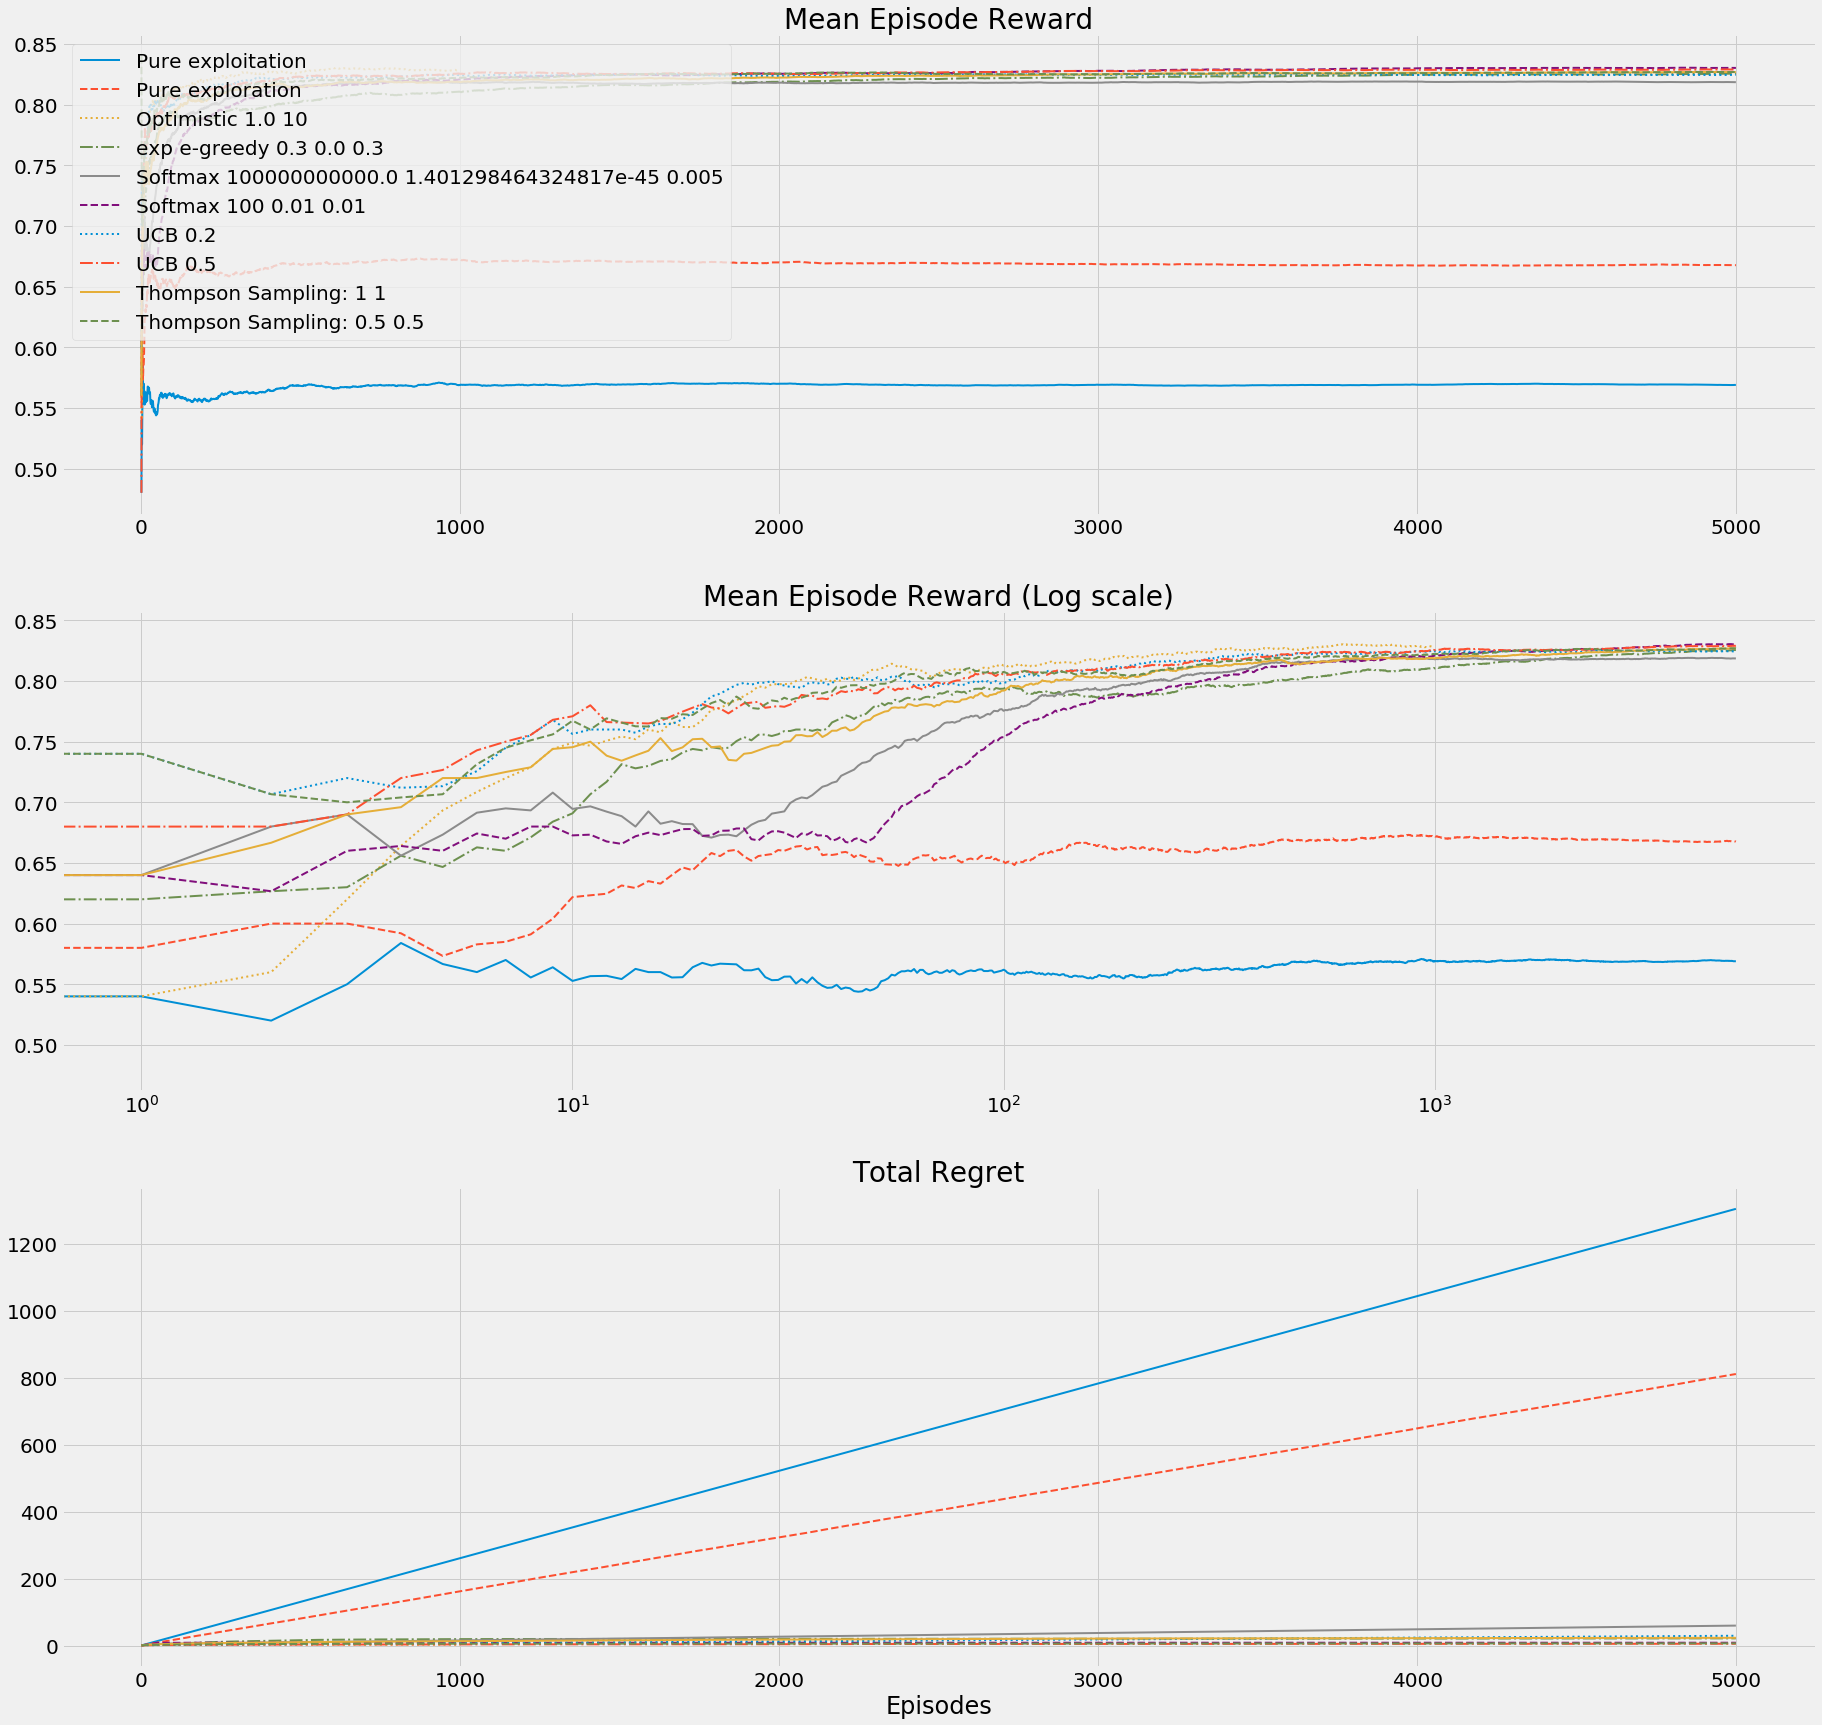

In [105]:
plot(results)


# 10 armed Bandit

In [109]:
env_name = "BanditTenArmedGaussian-v0"


def tester_function2(test_functions):
    results = {}
    for seed in tqdm(SEEDS, desc="All tests"):
        env = gym.make(env_name, seed=seed)
        env.reset()
        true_Q = np.array(env.env.p_dist * env.env.r_dist)
        opt_v = np.max(true_Q)
        for test_seed in tqdm(SEEDS, desc="All seeds"):
            for test_function in tqdm(
                test_functions, desc=f"Function with seed: {test_seed}"
            ):

                name, returns, Qe, actions = test_function(env)
                actions = np.expand_dims(actions, -1)
                episode_mean_rew = np.cumsum(returns) / (np.arange(len(returns)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, actions.shape), actions, axis=1
                ).squeeze()
                regret = opt_v - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {
                        "returns": [],
                        "Qe": [],
                        "actions": [],
                        "episode_mean_rew": [],
                        "cum_regret": [],
                    }
                results[name]["returns"].append(returns)
                results[name]["Qe"].append(Qe)
                results[name]["actions"].append(actions)
                results[name]["episode_mean_rew"].append(episode_mean_rew)
                results[name]["cum_regret"].append(cum_regret)
    return results


In [110]:
results = tester_function2(exp4)

All tests:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (10,) (10,2) 

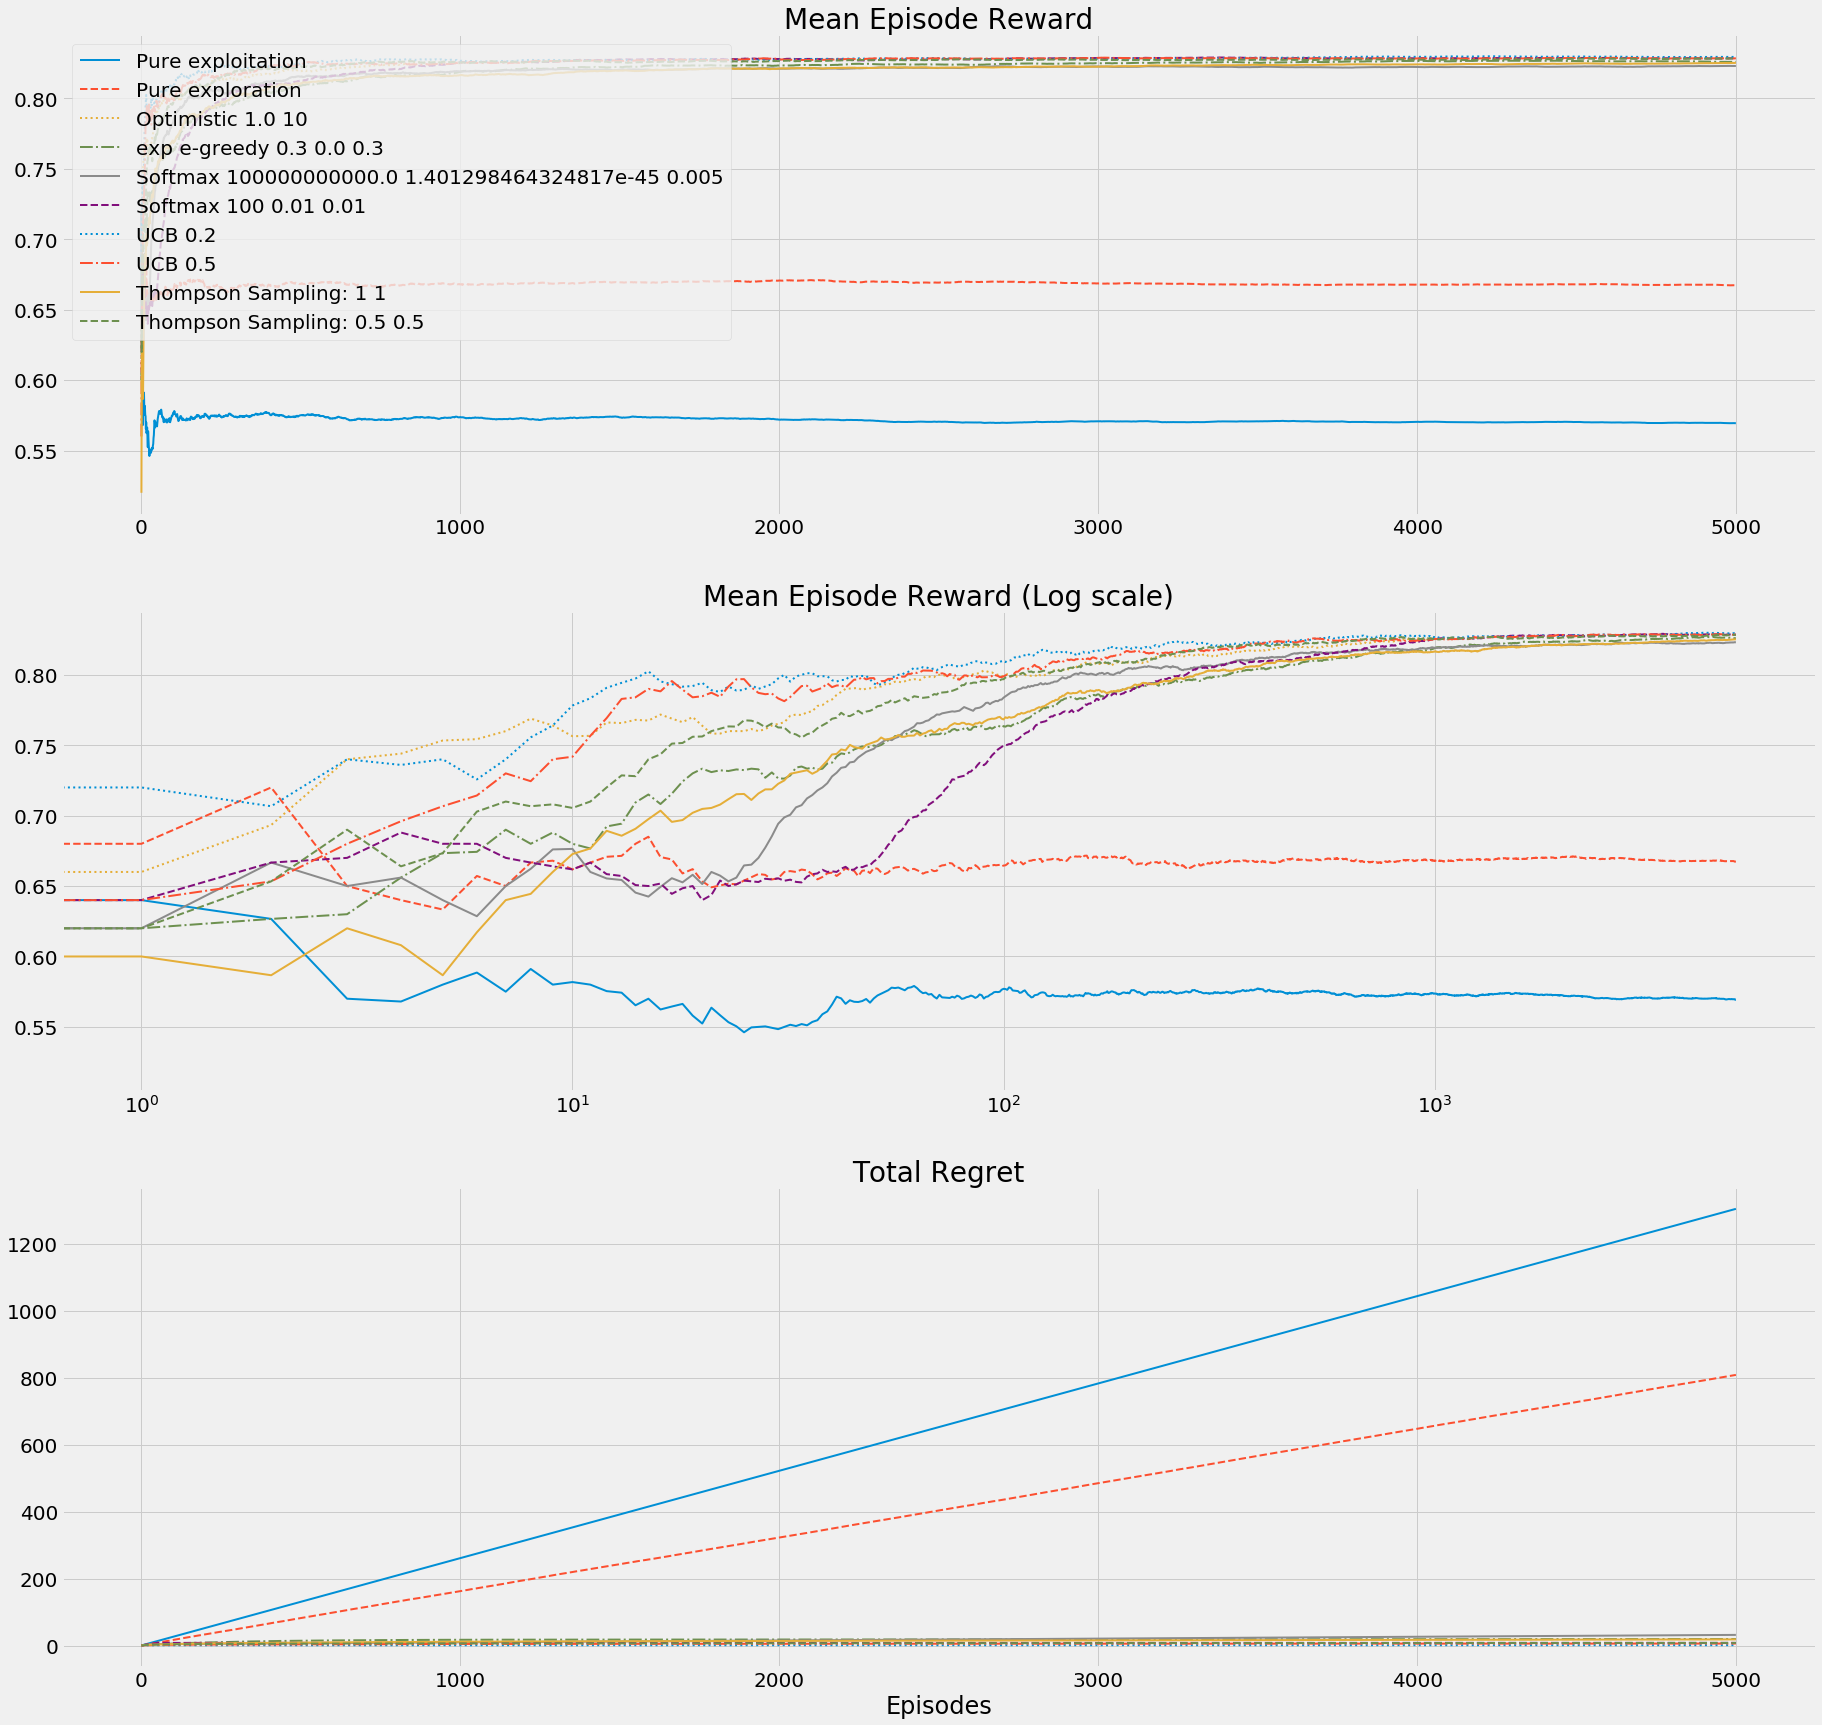

In [ ]:
plot(results)